# Analysis of different initilaizations under the mean field scaling

The goal of this notebook is to study the impact of different initialization of multilayer fully-connected neural networks under the mean field scaling where layer outputs are divided by the number of units. For a network with layer sizes $(m_1, \ldots, m_{L-1})$ ($m_L=1$ since the we take the output of the network to be in $\mathbb{R}$), the output of the network with weights $\theta:=\left(w^l_{i,j}\right)_{l \in [L], i \in [m_l], j \in [m_{l-1}]}$ (with $m_0 = d+1$) is given by :
$$f(\theta; x) = \frac{1}{m_{L-1}} \sum_{i_{L-1}=1}^{m_{L-1}}w^L_{i_{L-1}} \sigma \left(\frac{1}{m_{L-2}} \sum_{i_{L-2}=1}^{m_{L-2}} w^{L-1}_{i_{L-1}, i_{L-2}} \sigma \left( \ldots \frac{1}{m_1} \sum_{i_1=1}^{m_1}w^2_{i_2, i_1}\sigma \left({w^1_{i_1}}^{T} x \right)  \right) \right)$$
We want to study the distributions of the weights of the different layers, as well as each layer's output when the number of units $m_{l}$ in each layer go to infinity. We will discuss two different cases:
1. For each $l$, for any $m_l$, the weights $w^l$ of layer $l$ are intitialized i.i.d. using the same law $\rho_l$ over $\mathbb{R}$ which does **not** depend on $m_l$. In this case, for any $l$, for any $m_l, k_l$ and for any $i \in [m_l]$, $j \in [k_l]$, ${w^l_i}^{(m_l)}$ and ${w^l_j}^{(k_l)}$ are i.i.d.
2. For each $l$, for any $m_l$, the weights $w^l$ of layer $l$ are intitialized i.i.d. using a law $\rho^{(m_l)}_l$ over $\mathbb{R}$ which **can** potentially depend on $m_l$. In this case, for $k_l \neq m_l$  the weights of the $l$-th layer might be drawn from a different distribution when the width is $m_l$ than when the width is $k_l$.

Let us note that what is done in practice rather corresponds to the second case (e.g. Glorot initialization). To study the consequences on the network with large width of these different type of intialization we will use:
- for the first case, $\rho = \mathcal{U}[-1,1]$ or $\rho = \mathcal{N}(0, 1)$
- for the second case $\rho = $ Glorot uniform or $\rho = $ Glorot normal initialization. 
- We might try again the second case, and re-scale the init by $m_l$ or $\sqrt{m_l}$ since the MF scaling has reduced each layer's output. 

Note that the intialization law is **always centered** around 0, and this will matter for the discussion. To simplify the analysis, we will consider layers of equal size $m$ and $\sigma=$ ReLU, with $L$ = 2 or 3.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import math
import pandas as pd

In [3]:
import sys
sys.path.insert(0, '/Users/karlhajjar/Documents/projects/wide-networks/')

from utils.plot.initialization import *

## Defining the network class

In [4]:
class WideLayer(nn.Module):
    """
    A class implementing a standard fully-connected layer with ReLU activations in the MF-scaling: i.e. where the 
    output of the layer is re-scaled by 1/m where m is the number of hidden units.
    """
    def __init__(self, scale, in_features, out_features, scaling='mf', activation=None, bias=True):
        super().__init__()
        if scaling == 'ntk':
            scale = np.sqrt(scale)
        elif scaling == 'mf':
            pass
        else:
            raise ValueError("scaling {} not implemented".format(scaling))
        self.scale = scale
        self.scaling = scaling
        if activation is not None:
            self.layer = nn.Sequential(nn.Linear(in_features=in_features, out_features=out_features, bias=bias),
                                       activation)
        else:
            self.layer = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)
        
    def forward(self, x):
        return  self.scale * self.layer.forward(x)

In [5]:
class FCNetwork(nn.Module):
    """
    A class implementing a standard fully-connected network with ReLU activations in the MF-scaling.
    """
    def __init__(self, L, m, d=100, bias=False, init=None, scaling='mf', init_params=None):
        super().__init__()
        assert L >= 2, "m must be > 1 but was {:,}".format(m)
        self.L = L
        self.m = m
        self.scaling = scaling
        
        self.layer_sizes = [(d,m)] + [(m,m)] * (L-2) + [(m,1)]
        self.biases = [True] + [bias] * (L-1)
        self.activations = [sigma] * (L-1) + [None]
        self.scales = [1.0] + [1.0 / m] * (L-1)
        assert len(self.layer_sizes) == len(self.biases) == L
        
        self.layers = nn.Sequential(*[WideLayer(scale=self.scales[l],
                                                in_features=self.layer_sizes[l][0], 
                                                out_features=self.layer_sizes[l][1], 
                                                activation=self.activations[l],
                                                bias=self.biases[l],
                                                scaling=scaling) for l in range(L)])
        if init is not None:
            self.initialize_params(init, init_params)
        
    def initialize_params(self, init, init_params):
        initializer = INIT_DICT[init]
        for p in self.parameters():
            if p.dim() > 1:
                if init_params is not None:
                    initializer(p, **init_params)
                else:
                    initializer(p)
            else:  # initialize biases
                # TODO : to complete later
                pass
        
    def forward(self, x):
        return self.layers.forward(x)

## Defining the constant variables for all the experiments

In [6]:
INIT_DICT = {'glorot_uniform': torch.nn.init.xavier_uniform_,
             'glorot_normal': torch.nn.init.xavier_normal_,
             'normal': torch.nn.init.normal_,
             'uniform': torch.nn.init.uniform_}

In [7]:
sigma = nn.ReLU()
d = 100  # dimension of the input data
n = int(1e3)  # number of samples considered
Ms = [50, 100, 200, 500, 1000, 2000, 5000]  #, 10000 , 20000, 50000
n_trials = 20
L = 3
x = 2 * torch.rand((n,d))
figsize = (14,8)

In [8]:
def define_networks(L, ms, d, init, init_params, n_trials, bias=False, scaling='mf', scale_init=None):
    nets = dict()
    for m in Ms:
        nets_ = []
        if (scale_init is not None) and (init_params is not None):
            _rescale_init(init_params, scale_init, m)
        for _ in range(n_trials):
            net = FCNetwork(L=L, m=m, d=d, bias=bias, init=init, scaling=scaling, init_params=init_params) 
            net.eval()  # set validation mode to disable autograd and release memory
            nets_.append(net)
        nets[m] = nets_
    return nets

def _rescale_init(init_params, scale_init, scale):
    if scale_init == 'lin':
        for k, v in init_params.items():
            init_params[k] = scale * v
    elif scale_init == 'sqrt':
        for k, v in init_params.items():
            init_params[k] = np.sqrt(scale) * v
    else: 
        raise ValueError("init scaling {} is not implemented".format(scale_init))

In [9]:
def generate_plots(figsize, L, ms, d, init, init_params, n_trials, scaling, bias=False, scale_init=None):
    nets = define_networks(L, ms, d, init, init_params, n_trials, bias=bias, scaling=scaling, scale_init=scale_init)
    layers_outputs_df = get_layers_outputs_df(nets, inputs=x)

    title = 'Mean absolute value of layers outputs vs m in the {} scaling'.format(scaling)
    plot_average_over_trials(layers_outputs_df, x='m', y='average output absolute mean', hue='l', 
                         figsize=figsize, title=title)
    plt.show()
    print('\n\n')

    for l in range(L):
        layer_outputs_l = layers_outputs_df.loc[layers_outputs_df.l == l, :]
        title = 'Mean absolute value of layer {:,} vs m in the {} scaling'.format(l, scaling)
        plot_average_over_trials(layer_outputs_l, x='m', y='average output absolute mean', figsize=figsize,
                                 title=title)
        plt.show()

## Setting the seeds for reproducibility

In [10]:
def set_random_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [11]:
set_random_seeds()

## 1. The case i.i.id. independent of the layer size

### 1.1. Uniform initialization

In [12]:
init = 'uniform'
init_params = {'a': -2.0, 'b': 2.0}

#### 1.1.1 MF scaling

In [13]:
scaling = 'mf'

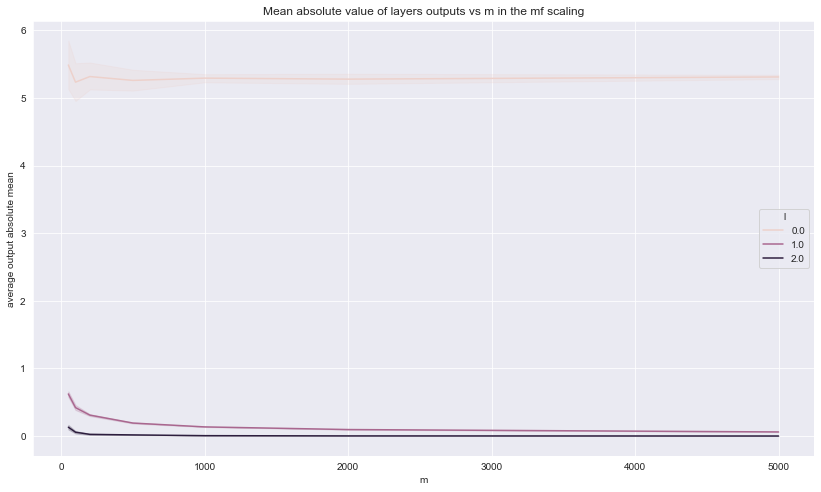

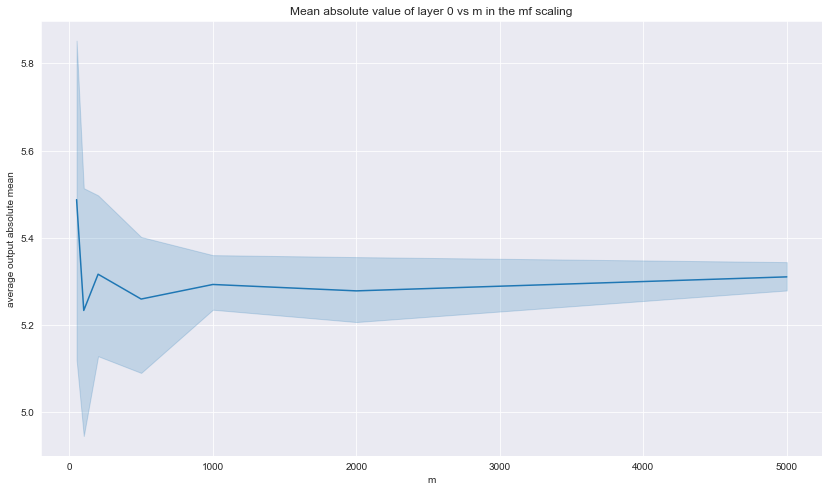

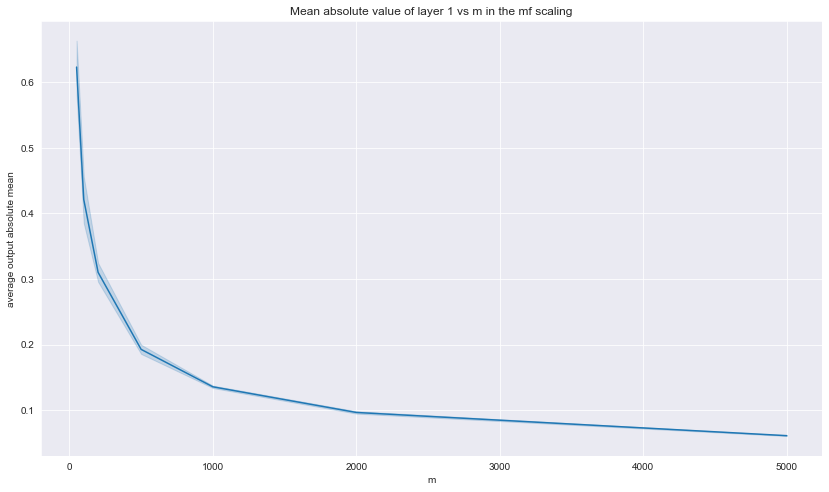

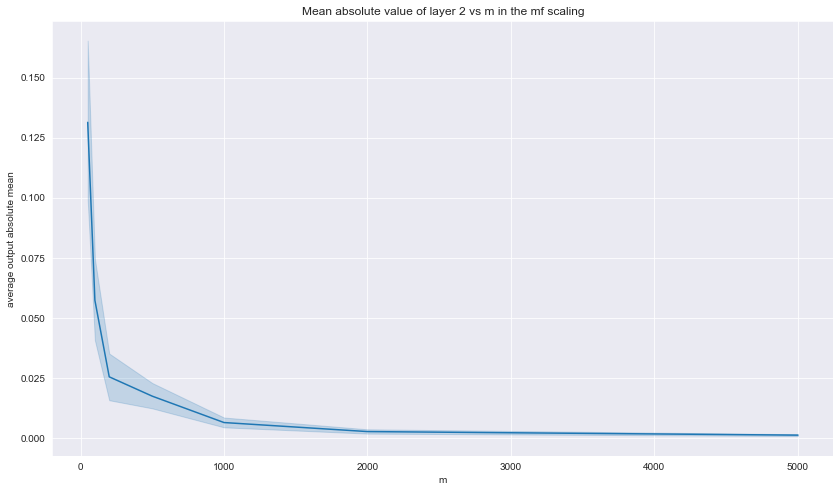

In [14]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 1.1.2 NTK scaling

In [15]:
scaling = 'ntk'

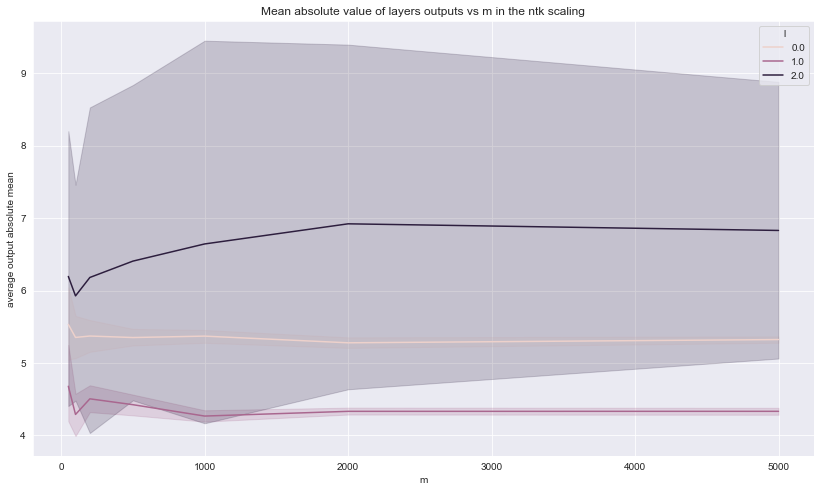

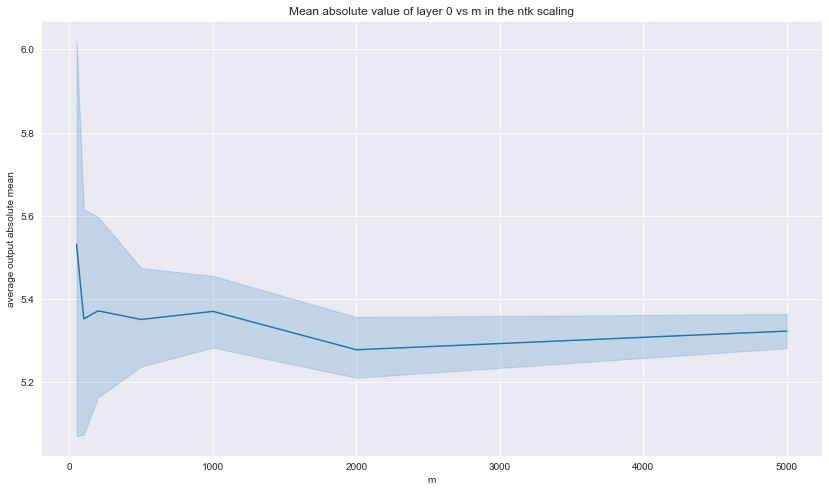

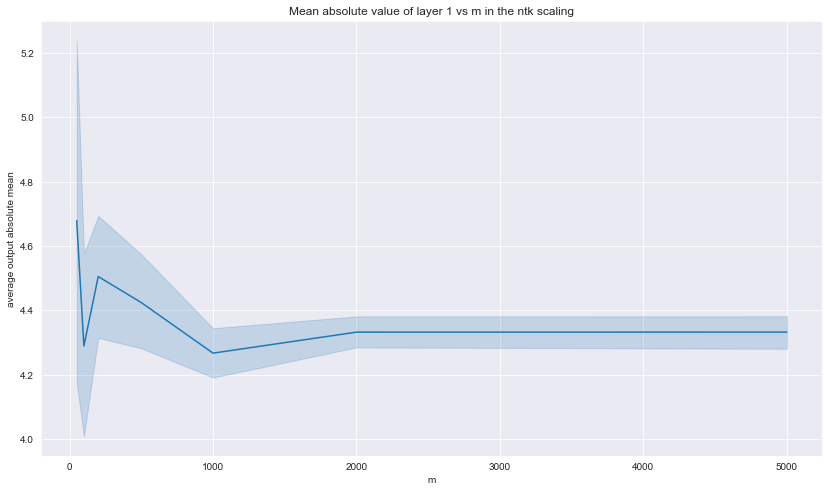

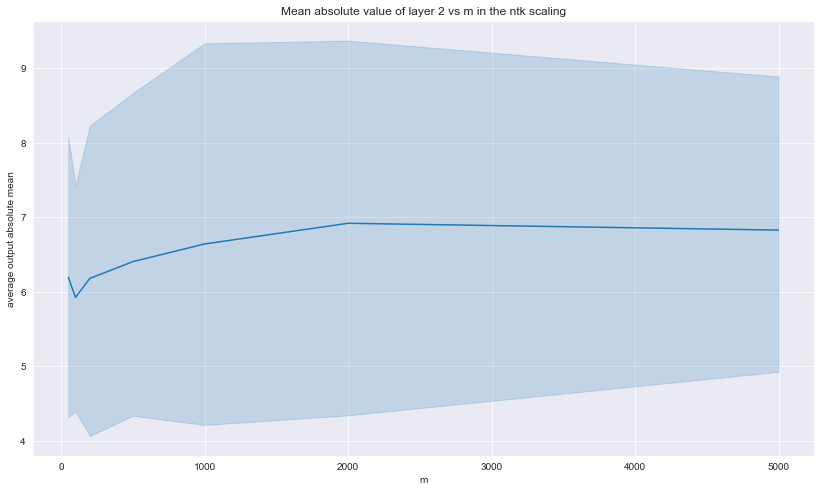

In [16]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

### 1.2. Normal initialization

In [17]:
init = 'normal'
init_params = {'mean': 0.0, 'std': 2.0}

#### 1.2.1 MF scaling

In [18]:
scaling = 'mf'

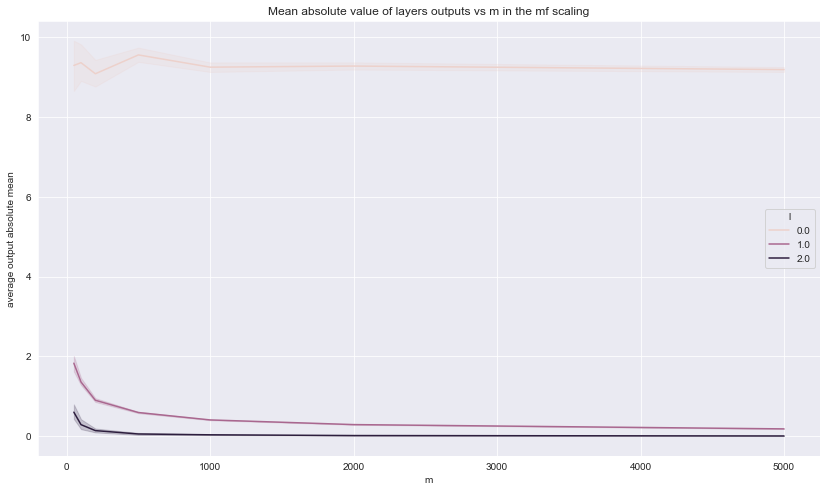

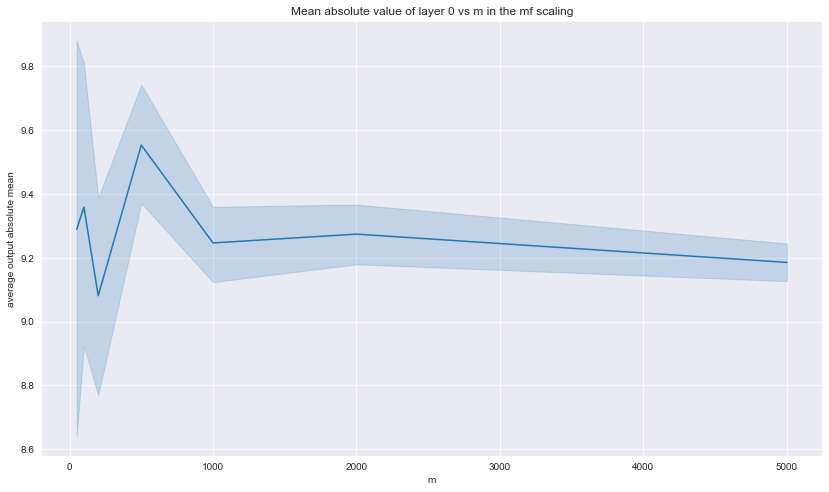

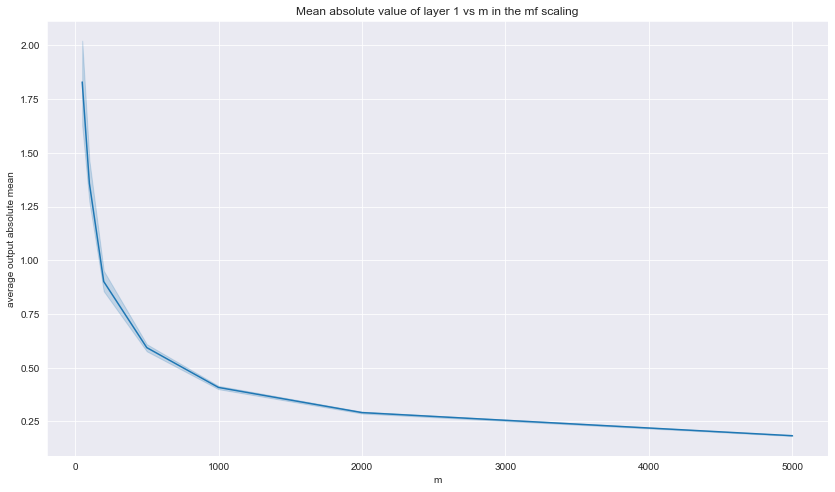

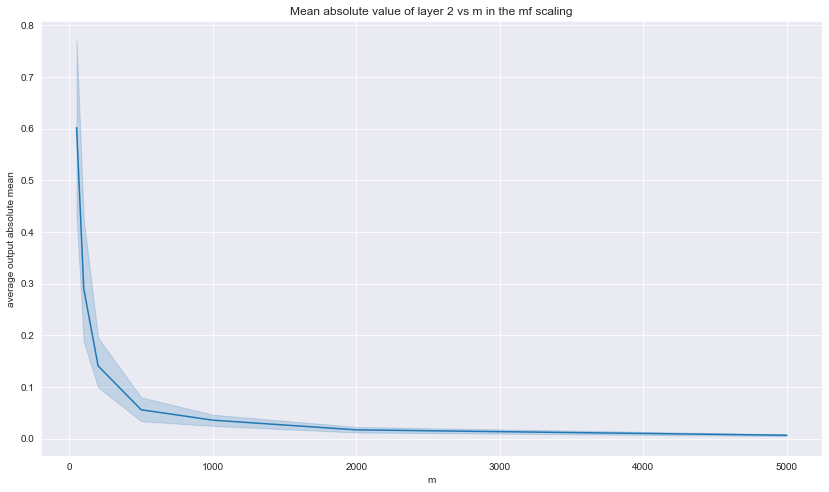

In [19]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 1.2.2 NTK scaling

In [20]:
scaling = 'ntk'

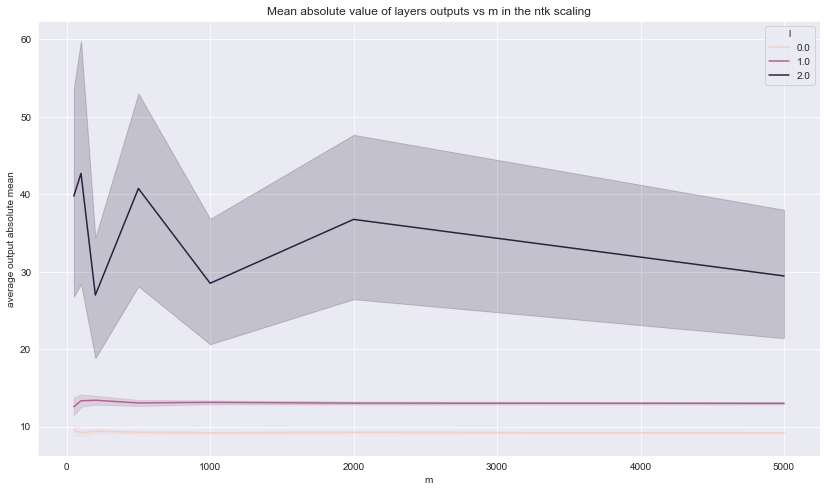

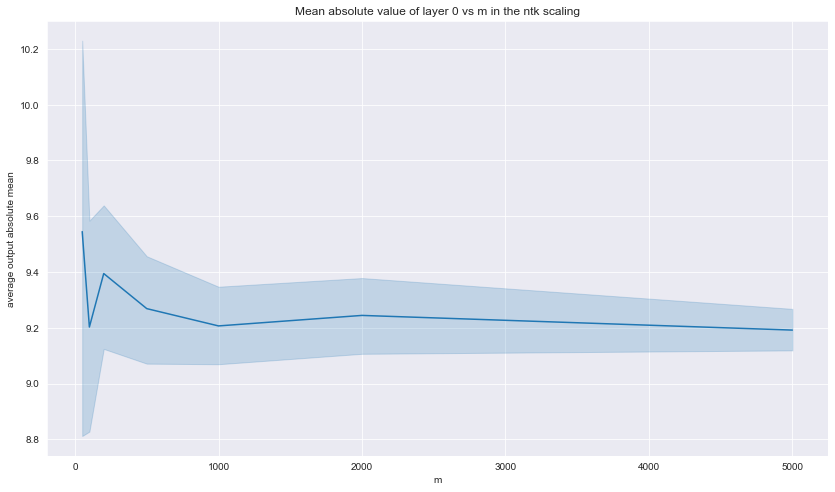

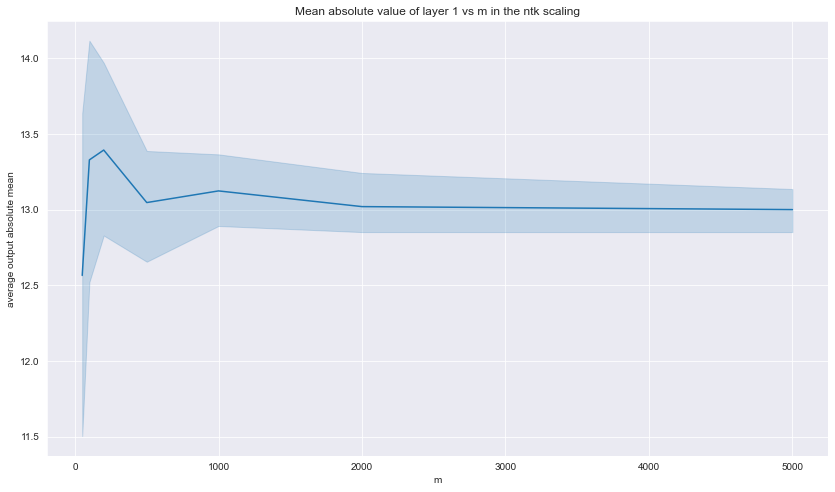

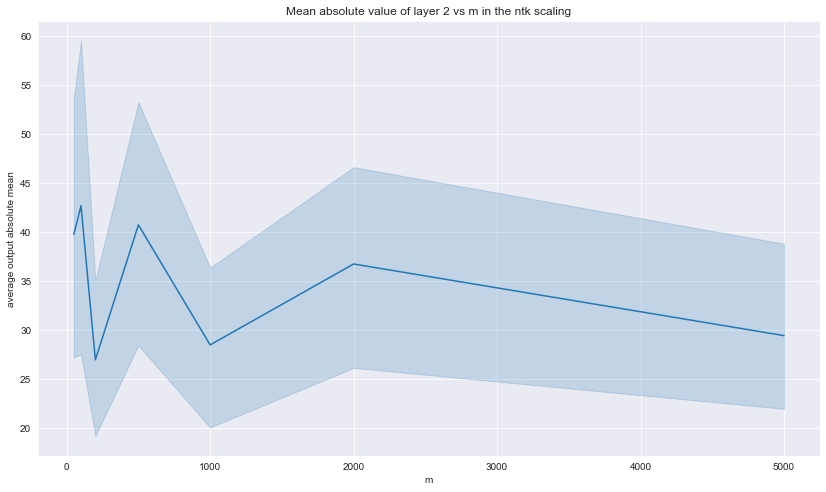

In [21]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

## 2. The case i.i.id. dependent of the layer size with Glorot init

### 2.1. Glorot uniform initialization

In [22]:
init = 'glorot_uniform'
init_params = {'gain': 2.0}

#### 2.1.1 MF scaling

In [23]:
scaling = 'mf'

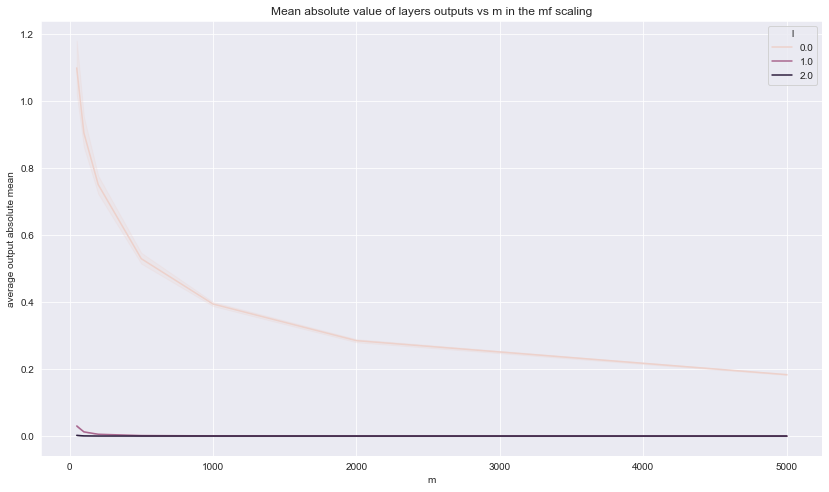

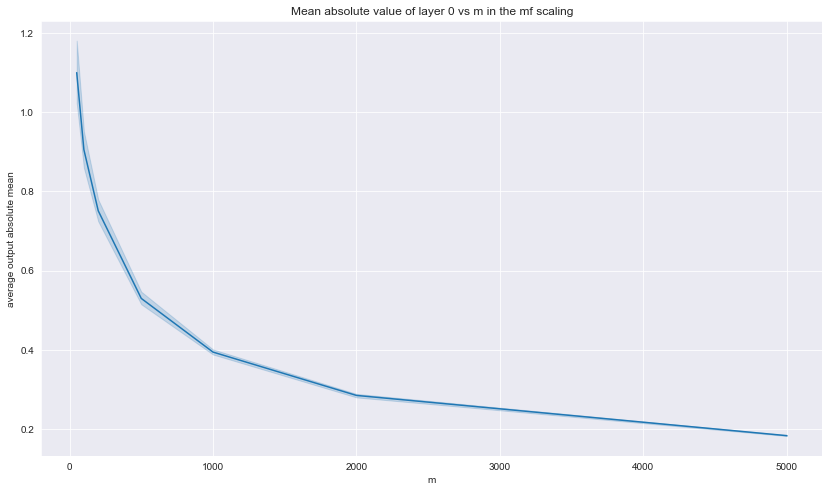

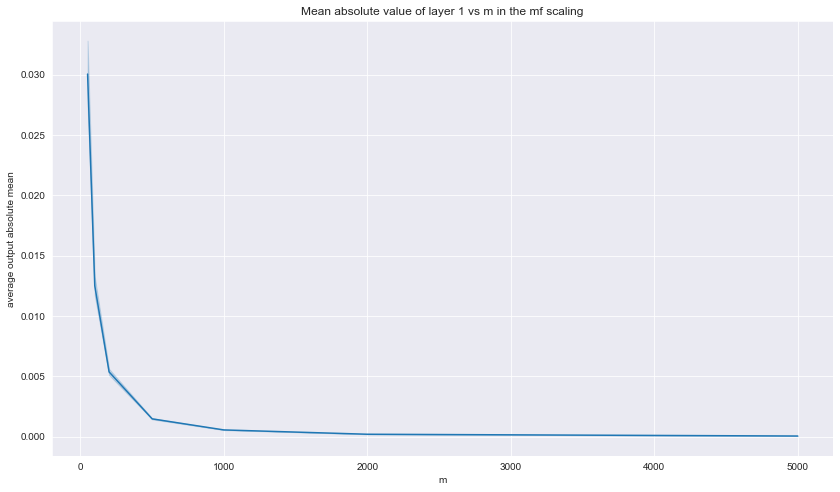

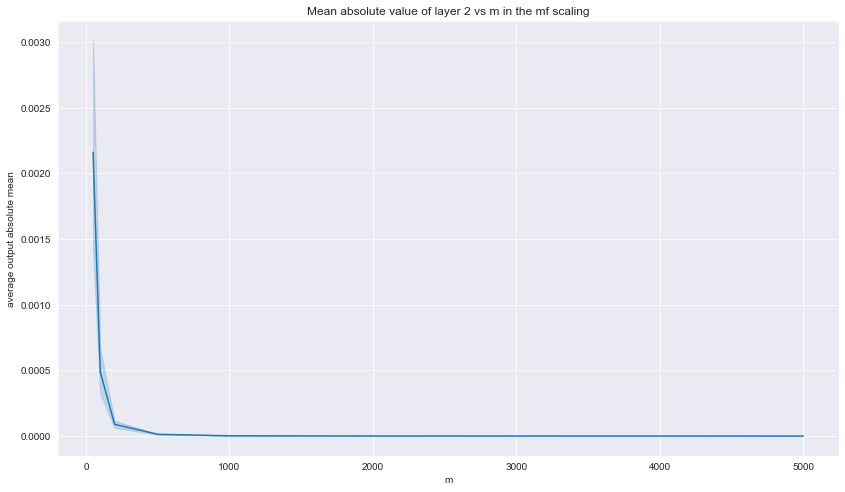

In [24]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 2.1.2 NTK scaling

In [25]:
scaling = 'ntk'

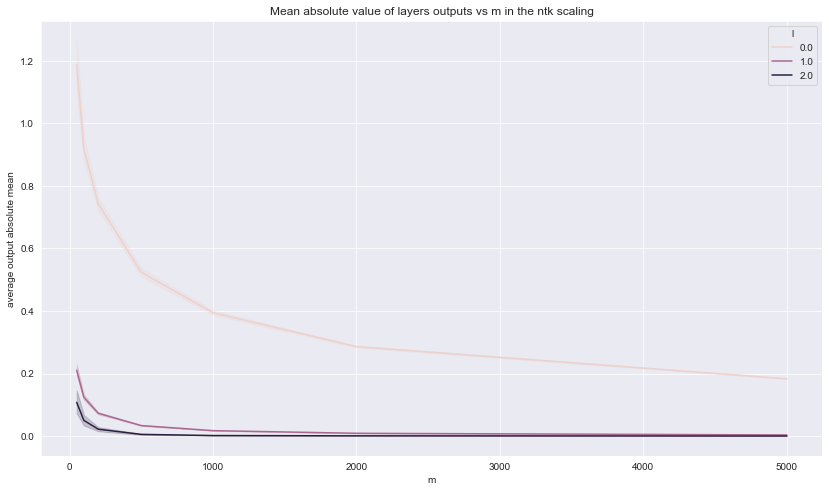

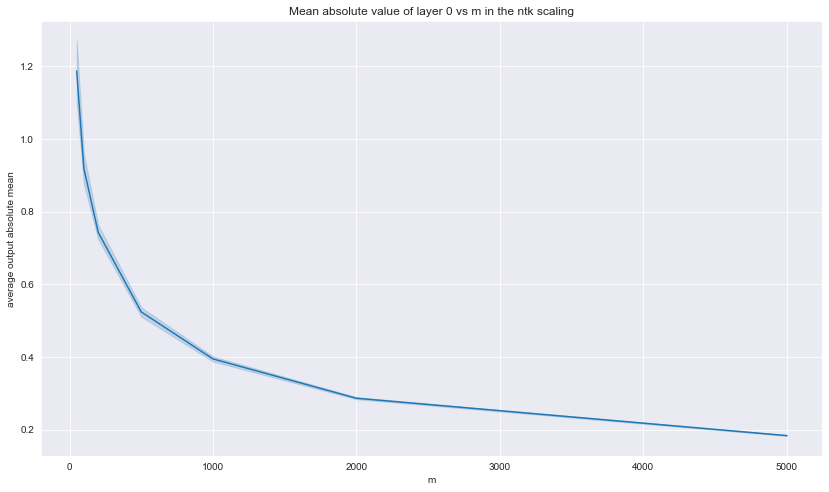

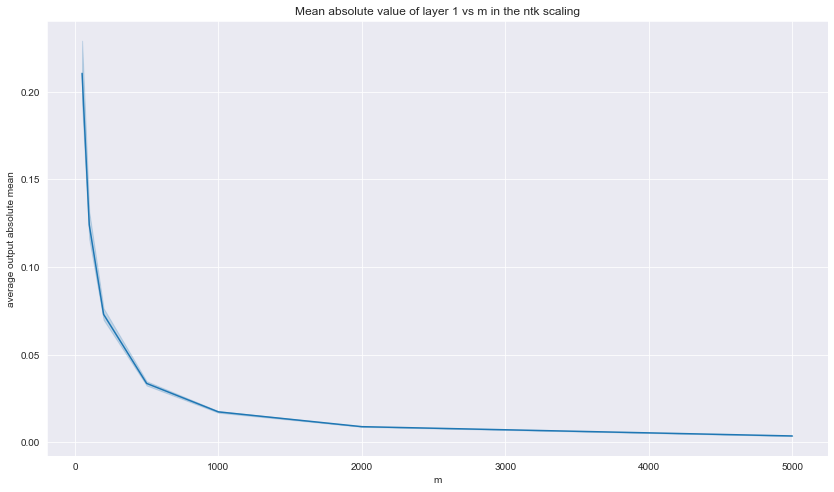

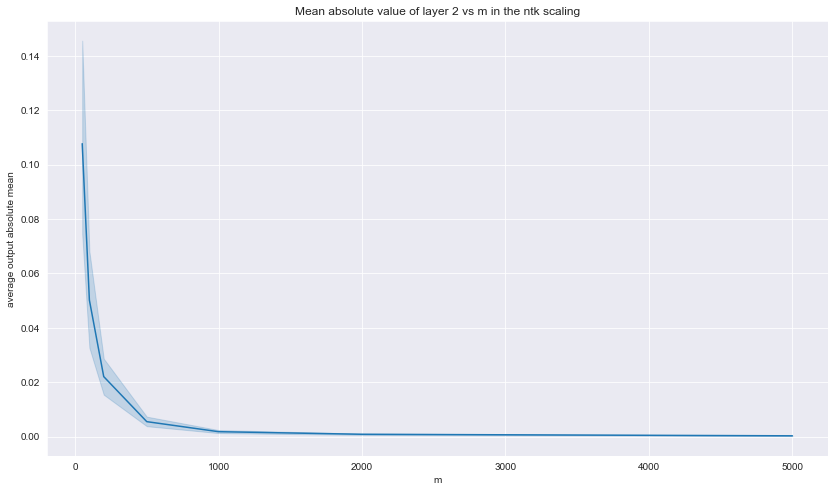

In [26]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

### 2.2. Glorot normal initialization

In [27]:
init = 'glorot_normal'
init_params = {'gain': 2.0}

#### 2.2.1 MF scaling

In [28]:
scaling = 'mf'

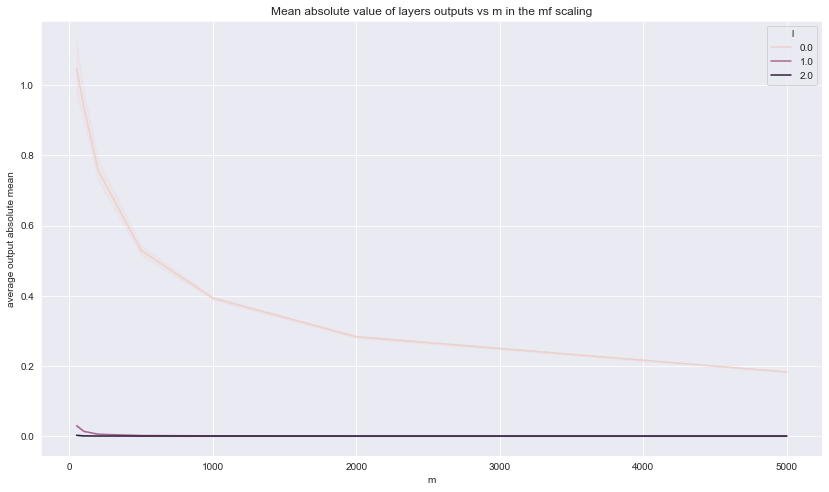

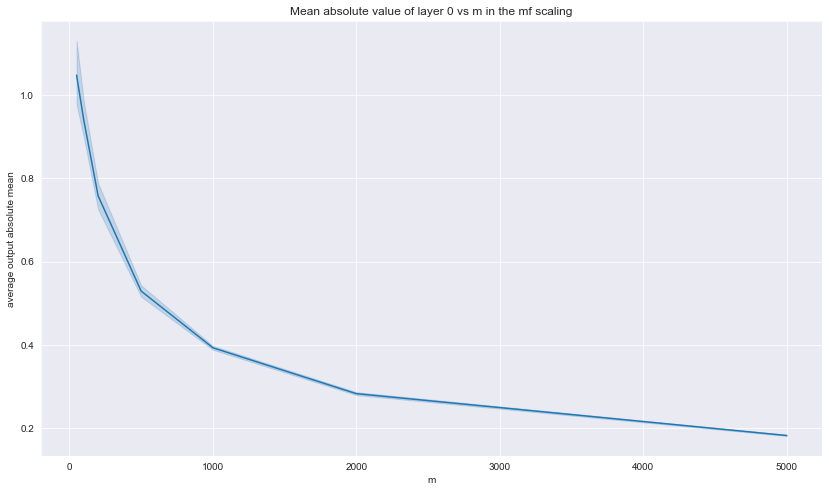

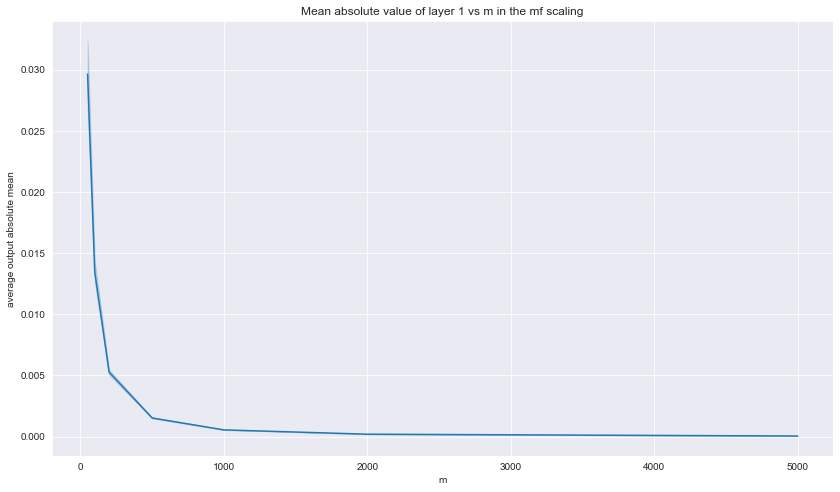

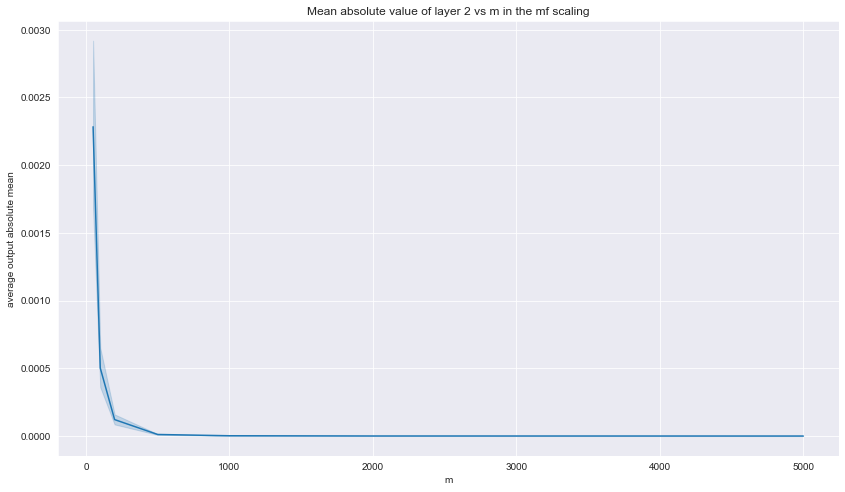

In [29]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

#### 2.2.2 NTK scaling

In [30]:
scaling = 'ntk'

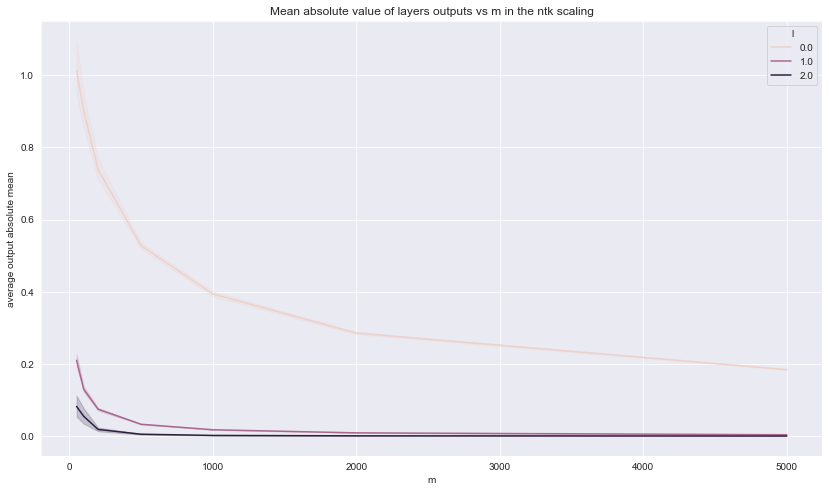

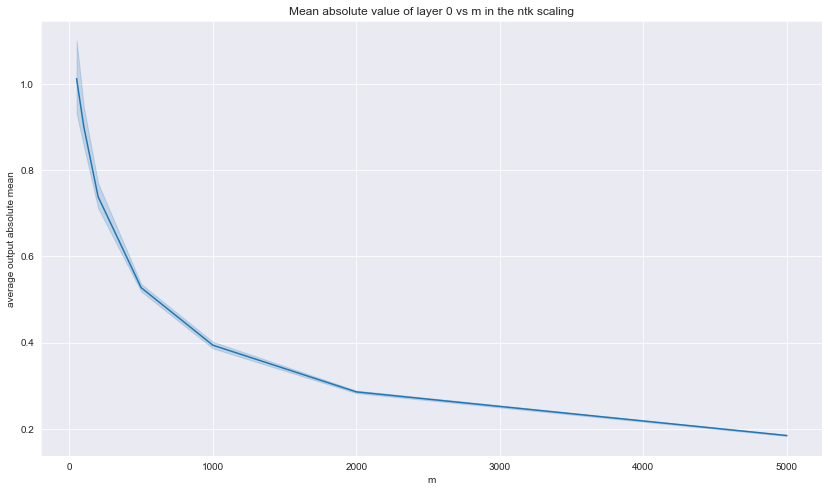

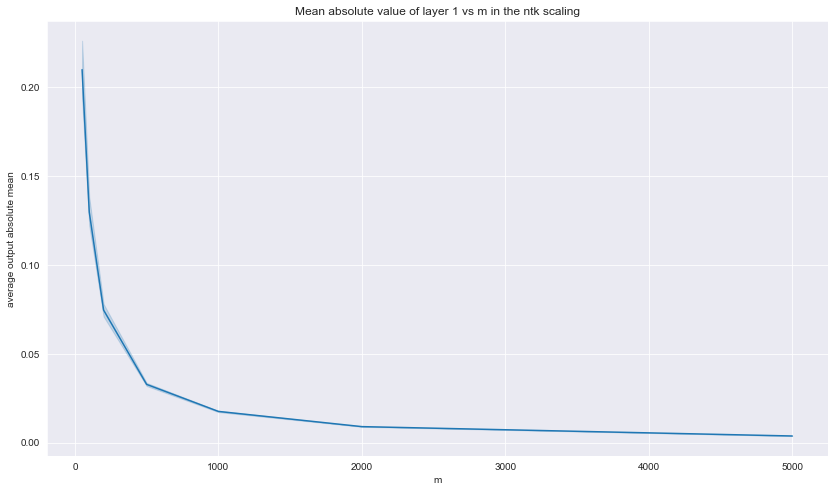

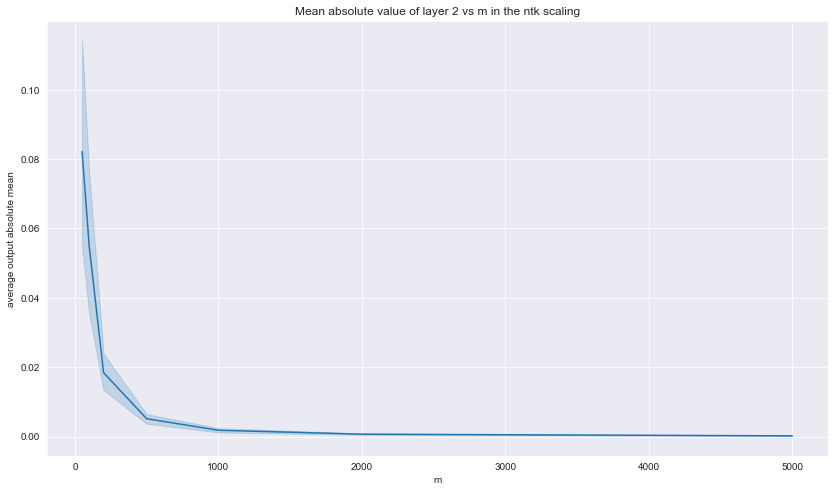

In [31]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False)

## 3. The case i.i.id. dependent of the layer size in $m$

### 3.1. Uniform initialization

In [42]:
init = 'uniform'
init_params = {'a': -1, 'b': 1.0}

#### 3.1.1 MF scaling

In [43]:
scaling = 'mf'

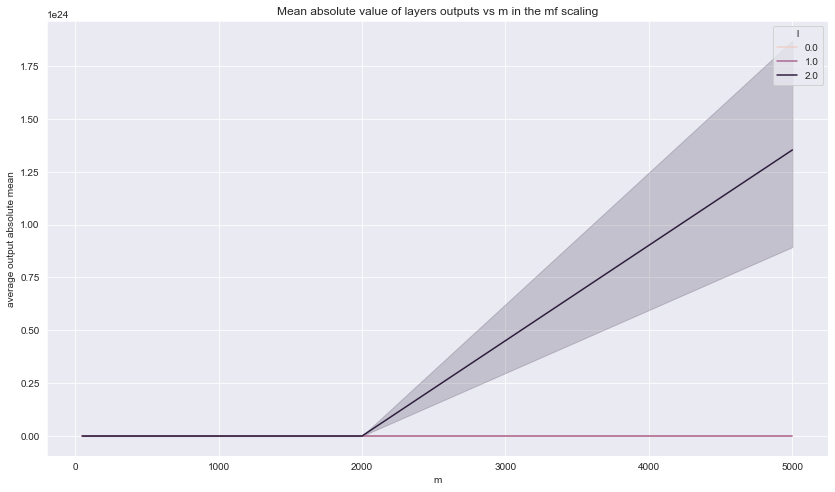

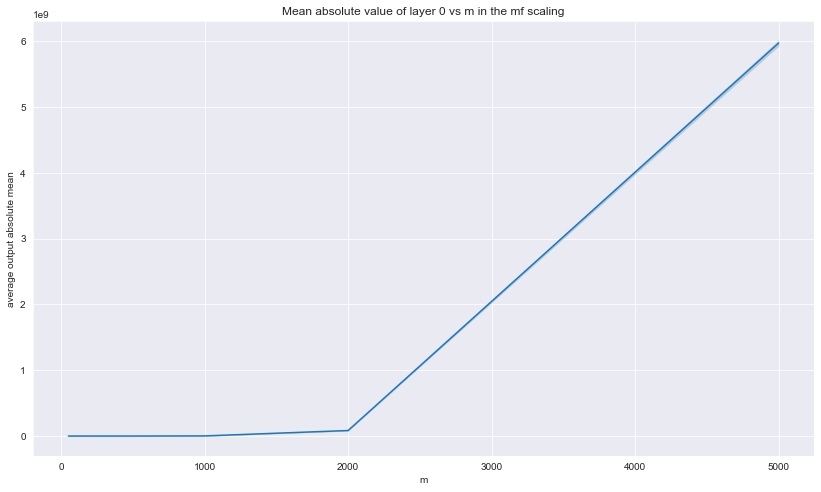

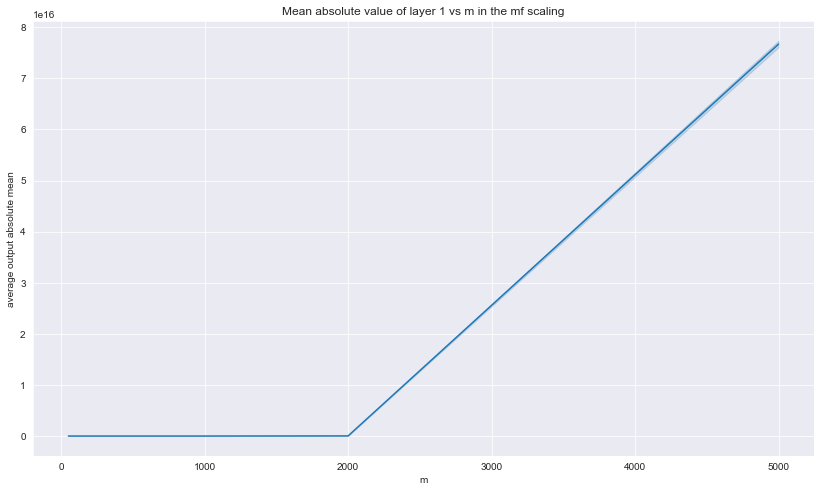

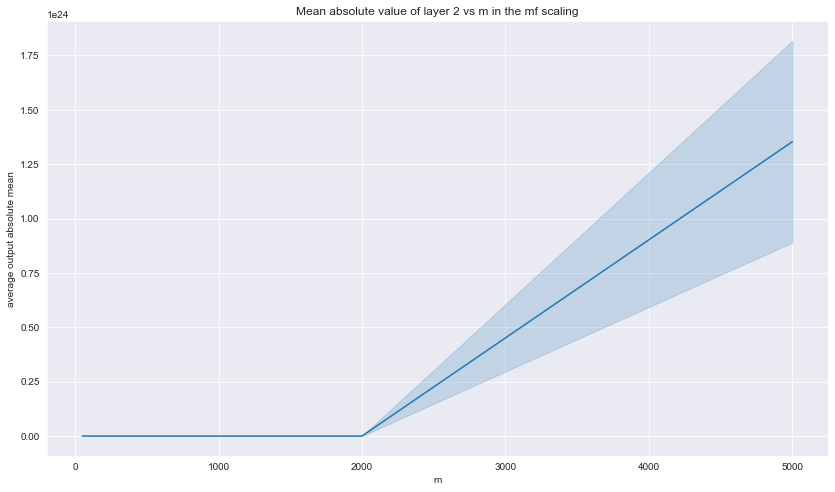

In [44]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')

### 1.2. Normal initialization

In [47]:
init = 'normal'
init_params = {'mean': 0.0, 'std': 2.0}

#### 1.2.1 MF scaling

In [48]:
scaling = 'mf'

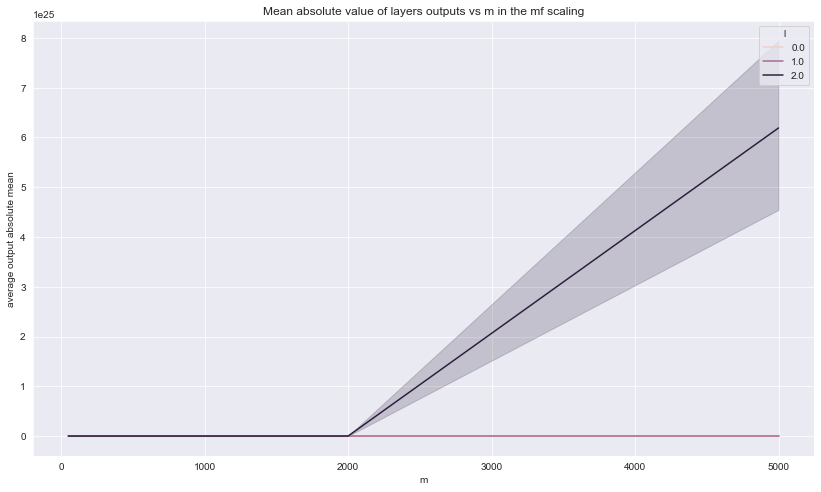

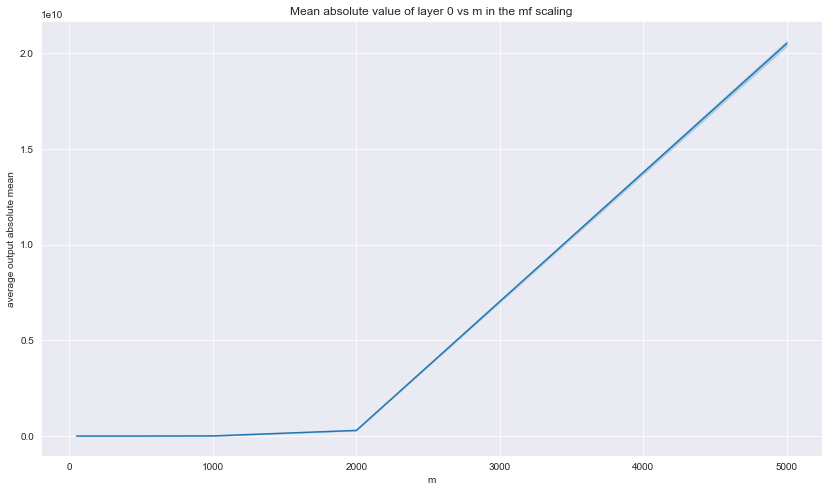

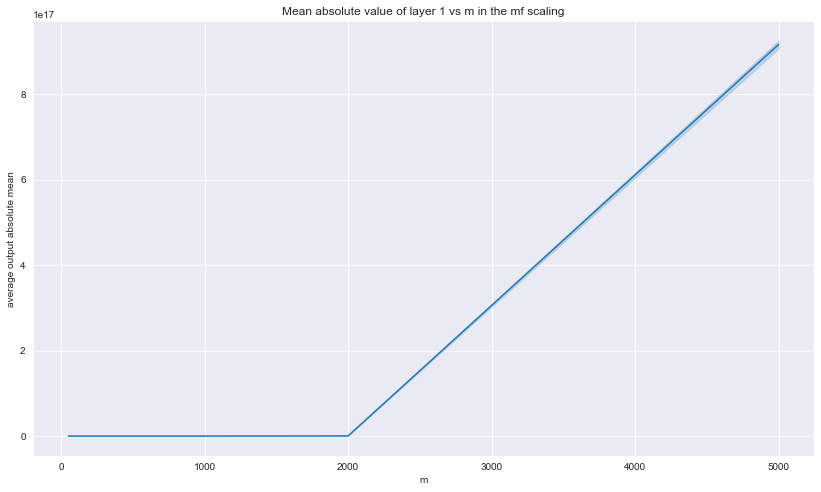

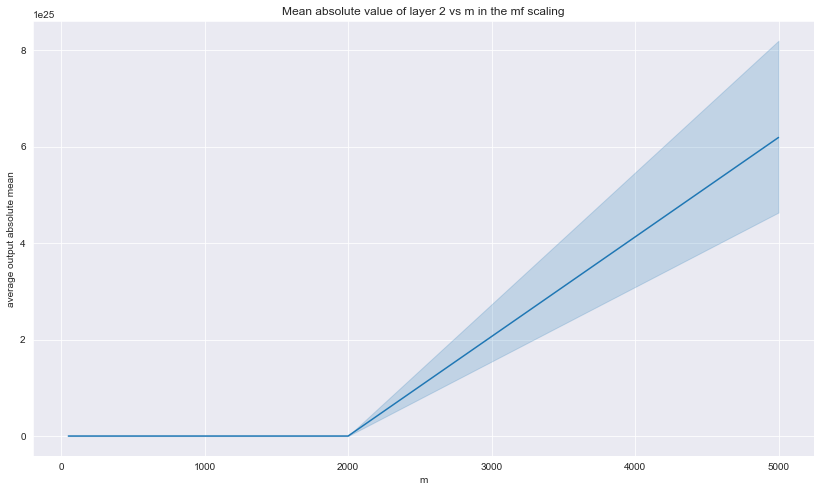

In [49]:
generate_plots(figsize, L, Ms, d, init, init_params, n_trials, scaling, bias=False, scale_init='sqrt')